<a href="https://colab.research.google.com/github/lblogan14/deep_learning_for_computer_vision/blob/master/ch3_image_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My' 'Drive/Colab' 'Notebooks/Deep_Learning_for_Computer_Vision/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Deep_Learning_for_Computer_Vision


In [0]:
import tensorflow as tf
import os
import numpy as np

Deep learning can also be called **representation learning** because the features
or representations in the model are learned during training. The **visual features**
generated during the training process in the hidden layers can be used for
computing a distance metric. These models learn how to detect edges, patterns,
and so on at various layers, depending on the classification task.

#Visual Features
Deep learning models are often criticized for not being interpretable. A neural
network-based model is often considered to be like a black box because it's
difficult for humans to reason out the working of a deep learning model. The
transformations of an image over layers by deep learning models are non-linear
due to activation functions, so cannot be visualized easily.

Visualization can be done using the activation and gradient of the model. The
activation can be visualized using the following techniques:
* **Nearest neighbor**: a layer activation of an image can be taken and the nearest images of that activation can be seen together
* **Dimensionality reduction**: The dimension of the activation can be reduced
by **principal component analysis (PCA)** or **t-Distributed Stochastic
Neighbor Embedding (t-SNE)** for visualizing in two or three dimensions.
PCA reduces the dimension by projecting the values in the direction of
maximum variance. t-SNE reduces the dimension by mapping the closest
points to three dimensions.
* **Maximal patches**: One neuron is activated and the corresponding patch
with maximum activation is captured.
* **Occlusion**: The images are occluded (obstructed) at various positions and
the activation is shown as heat maps to understand what portions of the
images are important.

Any model architecture can be visualized with the filters of any layer. Only the
initial layers are comprehensible using the technique. The last layer is useful for
the nearest neighbor approach.

#Embedding Visualization
The embedding layer, which is the pre-final layer, can be visualized in two or three dimensions using TensorBoard.

First, we need to build a CNN model using TensorFlow. Here we will use the MNIST dataset.

In [0]:
tf.reset_default_graph()

In [62]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

input_size = 784
no_classes = 10
batch_size = 100
total_batches = 100

x_input = tf.placeholder(tf.float32, shape=[None, input_size])
y_input = tf.placeholder(tf.float32, shape=[None, no_classes])

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
def add_variable_summary(tf_variable, summary_name):
  with tf.name_scope(summary_name + '_summary'):
    mean = tf.reduce_mean(tf_variable)
    tf.summary.scalar('Mean', mean)
    with tf.name_scope('standard_deviation'):
      standard_deviation = tf.sqrt(tf.reduce_mean(tf.square(tf_variable - mean)))
    tf.summary.scalar('StandardDeviation', standard_deviation)
    tf.summary.scalar('Maximum', tf.reduce_max(tf_variable))
    tf.summary.scalar('Minimum', tf.reduce_min(tf_variable))
    tf.summary.histogram('Histogram', tf_variable)

In [0]:
# CNN construction
x_input_reshape = tf.reshape(x_input, [-1, 28, 28, 1], name='input_reshape')

convolution_layer_1 = tf.layers.conv2d(inputs=x_input_reshape,
                                       filters=64,
                                       kernel_size=[3,3],
                                       activation=tf.nn.relu)
add_variable_summary(convolution_layer_1, 'convolution1')

pooling_layer_1 = tf.layers.max_pooling2d(inputs=convolution_layer_1,
                                          pool_size=[2,2],
                                          strides=2)
add_variable_summary(pooling_layer_1, 'pooling1')

convolution_layer_2 = tf.layers.conv2d(inputs=pooling_layer_1,
                                       filters=128,
                                       kernel_size=[3,3],
                                       activation=tf.nn.relu)
add_variable_summary(convolution_layer_2, 'convolution2')

pooling_layer_2 = tf.layers.max_pooling2d(inputs=convolution_layer_2,
                                           pool_size=[2,2],
                                           strides=2)
add_variable_summary(pooling_layer_2, 'pooling2')

flattened_pool = tf.reshape(pooling_layer_2, [-1, 5*5*128], name='flattened_pool')
dense_layer = tf.layers.dense(inputs=flattened_pool,
                              units=1024,
                              activation=tf.nn.relu,
                              name='dense')
add_variable_summary(dense_layer, 'dense')

dropout_bool = tf.placeholder(tf.bool)
dropout_layer = tf.layers.dropout(inputs=dense_layer,
                                  rate=0.4,
                                  training=dropout_bool,
                                  name='dropout')

logits = tf.layers.dense(inputs=dropout_layer, units=no_classes, name='logits')
add_variable_summary(logits, 'logits')

In [0]:
with tf.name_scope('loss'):
  softmax_cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_input,
                                                                     logits=logits)
  loss_operation = tf.reduce_mean(softmax_cross_entropy, name='loss')
  tf.summary.scalar('loss', loss_operation)
  
with tf.name_scope('optimizer'):
  optimizer = tf.train.AdamOptimizer().minimize(loss_operation)
  
with tf.name_scope('accuracy'):
  with tf.name_scope('correct_prediction'):
    predictions = tf.argmax(logits, 1)
    correct_predictions = tf.equal(predictions, tf.argmax(y_input, 1))
  with tf.name_scope('accuracy'):
    accuracy_operation = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
tf.summary.scalar('accuracy', accuracy_operation)

session = tf.Session()

Now we need a metadata file that is a tab separated file.

Every line of the metadata file should have the labels of the images that are
going to be visualized. A new variable is required for storing the embedding that
is defined between session creation and initialization.

In [0]:
# Add the variable in between createing the session and initializing the graph
no_embedding_data = 1000
embedding_variable = tf.Variable(tf.stack(mnist.test.images[:no_embedding_data],
                                          axis=0),
                                 trainable=False)

The embedding variable should be made non-trainable by setting the parameter `trainable` to `False`

In [0]:
session.run(tf.global_variables_initializer())

In [0]:
merged_summary_operation = tf.summary.merge_all()
train_summary_writer = tf.summary.FileWriter('./tmp/ch3/train', session.graph)

test_images, test_labels = mnist.test.images, mnist.test.labels

In [0]:
for batch_no in range(total_batches):
  image_batch = mnist.train.next_batch(batch_size)
  _, merged_summary = session.run([optimizer, merged_summary_operation],
                                  feed_dict={x_input:image_batch[0],
                                             y_input:image_batch[1],
                                             dropout_bool:True})
  train_summary_writer.add_summary(merged_summary, batch_no)

Take MNIST test data and create a metadata file for visualization,

In [0]:
work_dir = './data/ch3'
metadata_path = './tmp/ch3/train/metadata.tsv'

with open(metadata_path, 'w') as metadata_file:
  for i in range(no_embedding_data):
    metadata_file.write('{}\n'.format(np.nonzero(mnist.test.labels[::1])[1:][0][i]))

Next, the projector config has to be defined. It
has to have a `tensor_name` which is the embedding variable name, the path to the
metadata file, and a sprite image. A sprite image is one image with small images
to denote the labels to be visualized with the embeddings.

In [71]:
from tensorflow.contrib.tensorboard.plugins import projector
projector_config = projector.ProjectorConfig()
embedding_projection = projector_config.embeddings.add()

embedding_projection.tensor_name = embedding_variable.name
embedding_projection.metadata_path = metadata_path
embedding_projection.sprite.image_path = os.path.join(work_dir + '/mnist_10k_sprite.png')
embedding_projection.sprite.single_image_dim.extend([28,28])

projector.visualize_embeddings(train_summary_writer, projector_config)
tf.train.Saver().save(session, './tmp/ch3/train/model.ckpt', global_step=1)

'./tmp/ch3/train/model.ckpt-1'

The sprite image dimension has to be specified. Then the projector can be used
to visualize the embedding with the summary writer and the configuration.

###Set up the TensorBoard in Colab to see the embedding visualization.

In [72]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2018-12-02 00:57:44--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.196.224.14, 34.199.255.1, 35.173.3.255, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.196.224.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.3’

ngrok-stable-linux- 100%[===================>]   5.11M  3.10MB/s    in 1.6s    

2018-12-02 00:57:47 (3.10 MB/s) - ‘ngrok-stable-linux-amd64.zip.3’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
LOG_DIR = './tmp/ch3'
get_ipython().system_raw(
      'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))

In [74]:
# run ngrok
# run ngrok to tunnel TensorBoard port 6006 to the outside world
get_ipython().system_raw('./ngrok http 6006 &')

# Get URL
# access the colab TensorBoard web page
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://04d4f393.ngrok.io


#Guided Backpropagation
We can use the training procedure of backpropagation to activate the filters for better visualization. The guided backpropagation is to pick what neurons are to be activated for backpropagation.

In [0]:
from scipy import imsave

Define the size and load the VGG model,

In [77]:
image_width, image_height = 128, 128
vgg_model = tf.keras.applications.vgg16.VGG16(include_top=False)

58892288/58889256 [==============================] - 5s 0us/step


The layers are made of a dictionary with layer names as keys, and the layer from
the model with weights as the key value for ease of access.

Take a first convolution layer from the fifth block, `block5_conv1` for computing the visualization.

In [0]:
input_image = vgg_model.input
vgg_layer_dict = dict([(vgg_layer.name, vgg_layer) for vgg_layer in vgg_model.layers[1:]])
vgg_layer_output = vgg_layer_dict['block5_conv1'].output

Next, define the loss function to maximize the activation of a particular layer. 

This is a gradient ascent process rather than the
usual gradient descent as we are trying to maximize the loss function. For
gradient ascent, it's important to smoothen the gradient. So we smoothen the
gradient in this case by normalizing the pixel gradients.

The output of the image should be normalized to visualize it back, gradient
ascent is used in an optimization process to get the maxima of a function.


In [83]:
filters = []
for filter_idx in range(20):
  loss = tf.keras.backend.mean(vgg_layer_output[:,:,:,filter_idx])
  gradients = tf.keras.backend.gradients(loss, input_image)[0]
  gradient_mean_square = tf.keras.backend.mean(tf.keras.backend.square(gradients))
  gradients /= (tf.keras.backend.sqrt(gradient_mean_square) + 1e-5)
  evaluator = tf.keras.backend.function([input_image], [loss, gradients])
  
  '''The input is a random grey image with some noise added to it. 
     A random image is generated and scaling is done.'''
  gradient_ascent_step = 1.
  input_image_data = np.random.random((1, image_width, image_height, 3))
  input_image_data = (input_image_data - 0.5) * 20 + 128
  
  '''Start the loss function optimization'''
  for i in range(20):
    loss_value, gradient_values = evaluator([input_image_data])
    input_image_data += gradient_values * gradient_ascent_step
    print('Loss : ', loss_value)
    if loss_value <= 0.:
      break
      
  '''Normailize the result
     Scale back and clip the filters to their gradient values'''
  if loss_value >0:
    filter = input_image_data[0]
    filter -= filter.mean()
    filter /= (filter.std() + 1e-5)
    filter *= 0.1
    filter += 0.5
    filter = np.clip(filter, 0, 255).astype('uint8')
    filters.append((filter, loss_value))

Loss :  12.438803
Loss :  28.160072
Loss :  44.44812
Loss :  68.395035
Loss :  87.79045
Loss :  118.47001
Loss :  144.18968
Loss :  172.8374
Loss :  196.3379
Loss :  220.5
Loss :  246.1461
Loss :  272.18436
Loss :  295.85846
Loss :  323.52295
Loss :  349.7285
Loss :  379.02948
Loss :  404.44427
Loss :  432.4129
Loss :  457.8572
Loss :  487.1454
Loss :  0.0
Loss :  7.8896422
Loss :  20.304886
Loss :  53.918526
Loss :  94.11244
Loss :  123.69983
Loss :  148.05835
Loss :  183.2275
Loss :  215.50385
Loss :  249.5362
Loss :  278.89008
Loss :  312.5717
Loss :  343.77774
Loss :  375.5897
Loss :  403.12946
Loss :  436.34235
Loss :  464.25854
Loss :  495.6029
Loss :  523.6949
Loss :  555.48096
Loss :  586.65515
Loss :  12.273309
Loss :  45.35696
Loss :  121.97977
Loss :  201.0448
Loss :  276.59457
Loss :  351.0529
Loss :  416.52643
Loss :  477.73697
Loss :  538.3696
Loss :  593.32654
Loss :  639.7555
Loss :  698.7921
Loss :  746.0359
Loss :  796.8221
Loss :  846.5514
Loss :  896.24536
Loss :  9

Visualize the result,

In [87]:
n = 3

filters.sort(key=lambda x:x[1], reverse=True)
filters = filters[:n * n]

margin = 5
width = n * image_width + (n-1) * margin
height = n * image_height + (n-1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
  for j in range(n):
    img, loss = filters[i * n + j]
    stitched_filters[(image_width + margin) * i: (image_width + margin) * i + image_width,
                     (image_height + margin) * j: (image_height + margin) * j + image_height, :] = img
    
imsave('stitched_filters_%dx%d.png' % (n,n), stitched_filters)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [0]:
import matplotlib.pyplot as plt

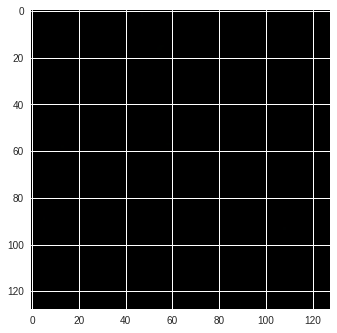

In [115]:
plt.imshow(filters[8][0])

#The DeepDream
The neuron activations can be amplified at some layer in the network rather than
synthesizing the image. This concept of amplifying the original image to see the
effect of features is called **DeepDream**.

The steps for creating the DeepDream
are:
1. Take an image and pick a layer from CNN.
2. Take the activations at a particular layer.
3. Modify the gradient such that the gradient and activations are equal.
4. Compute the gradients of the image and backpropagate.
5. The image has to be jittered and normalized using regularization.
6. The pixel values should be clipped.
7. Multi-scale processing of the image is done for the effect of fractal.

In [0]:
tf.reset_default_graph()

In [0]:
import os
import numpy as np
import cv2
import urllib.request
from tensorflow.python.platform import gfile
import zipfile

In this example, we will use the inception pre-trained model on the ImageNet dataset.

In [0]:
work_dir = './data/ch3'

model_url = 'https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip'
file_name = model_url.split('/')[-1]
file_path = os.path.join(work_dir, file_name)

if not os.path.exists(file_path):
  file_path, _ = urllib.request.urlretrieve(model_url, file_path)
  
zip_handle = zipfile.ZipFile(file_path, 'r')
zip_handle.extractall(work_dir)
zip_handle.close()

Load the pre-trained model into the session

In [121]:
graph = tf.Graph()
session = tf.InteractiveSession(graph=graph)
model_path = os.path.join(work_dir, 'tensorflow_inception_graph.pb')
with gfile.FastGFile(model_path, 'rb') as f:
  graph_definition = tf.GraphDef()
  graph_definition.ParseFromString(f.read())

Instructions for updating:
Use tf.gfile.GFile.


A session is started with the initialization of a graph. Then the graph definition
of the model downloaded is loaded into the memory.

Next, subtract the `imagenet` mean from the input as a preprocessing step

In [0]:
input_placeholder = tf.placeholder(np.float32, name='input')
imagenet_mean_value = 117.0
preprocessed_input = tf.expand_dims(input_placeholder - imagenet_mean_value, 0)
tf.import_graph_def(graph_definition, {'input':preprocessed_input})

Now the session and graph are ready for inference. 

Define two helper functions: the `resize_image` function will be
required with bilinear interpolation and the `resize` function method can be added that
resizes the image with a TensorFlow session,

In [0]:
def resize_image(image, size):
  resize_placeholder = tf.placeholder(tf.float32)
  resize_placeholder_expanded = tf.expand_dims(resize_placeholder, 0)
  resized_image = tf.image.resize_bilinear(resize_placeholder_expanded, size)[0,:,:,:]
  return session.run(resized_image, feed_dict={resize_placeholder:image})

Load an image and convert to float value,

In [0]:
image_name = './data/ch3/mountain.jpg'
image = cv2.imread(image_name)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = np.float32(image)
objective_fn = tf.square(graph.get_tensor_by_name('import/mixed4c:0'))

(-0.5, 1279.5, 719.5, -0.5)

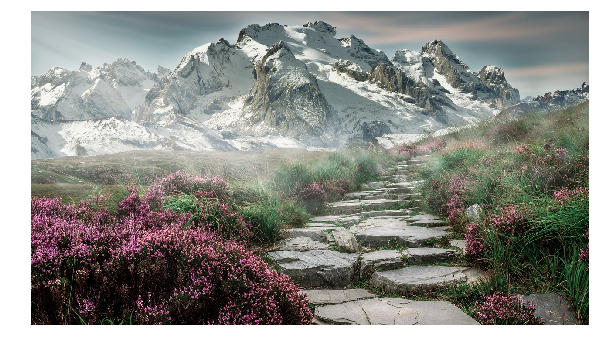

In [135]:
plt.figure(figsize=(10,8))
plt.imshow(image_rgb)
plt.axis('off')

In [0]:
no_octave = 4
scale = 1.4
window_size = 51

The above parameters depend upon the particular image. It needs to be tuned for other images based on their size.

Next, select a layer for dreaming and choose the average mean of that layer to be the objective function,

In [0]:
score = tf.reduce_mean(objective_fn)
gradients = tf.gradients(score, input_placeholder)[0]

Compute the gradient of the images for optimization. Compute the octave images by resizing the image to various scales and find the difference,

In [0]:
octave_images = []
for i in range(no_octave - 1):
  image_height_width = image.shape[:2]
  scaled_image = resize_image(image, np.int32(np.float32(image_height_width) / scale))
  image_difference = image - resize_image(scaled_image, image_height_width)
  image = scaled_image
  octave_images.append(image_difference)

Now the optimization can be run using all the octave images. The window is slid
across the image, computing the gradients activation to create the dream,

In [0]:
for octave_idx in range(no_octave):
  if octave_idx > 0:
    image_difference = octave_images[-octave_idx]
    image = resize_image(image, image_difference.shape[:2]) + image_difference
    
  for i in range(10):
    image_height, image_width = image.shape[:2]
    sx, sy = np.random.randint(window_size, size=2)
    shifted_image = np.roll(np.roll(image, sx, 1), sy, 0)
    gradient_values = np.zeros_like(image)
    
    for y in range(0, max(image_height - window_size//2, window_size), window_size):
      for x in range(0, max(image_width - window_size//2, window_size), window_size):
        sub = shifted_image[y:y+window_size, x:x+window_size]
        gradient_windows = session.run(gradients, {input_placeholder:sub})
        gradient_values[y:y+window_size, x:x+window_size] = gradient_windows
    
    gradient_windows = np.roll(np.roll(gradient_values, -sx, 1), -sy, 0)
    image += gradient_windows * (1.5 / (np.abs(gradient_windows).mean() + 1e-7))

Now the optimization to create the DeepDream is completed.

Clip the values and save and show the result,

(-0.5, 651.5, 366.5, -0.5)

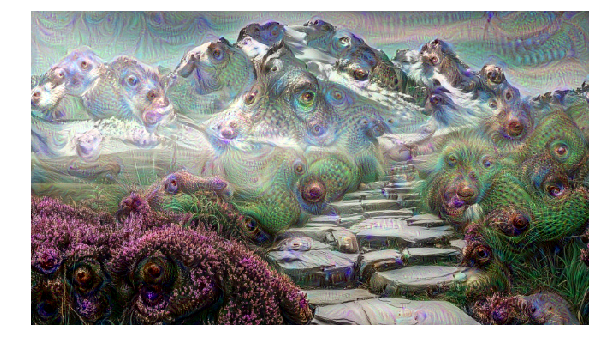

In [143]:
image /= 255.0
image = np.uint8(np.clip(image, 0, 1) * 255)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,8))
plt.imshow(image_rgb)
plt.axis('off')

The dog slugs are activated everywhere.... a little creepy.. You can try various other
layers and see the results.

#Model Inference
Any new data can be passed to the model to get the results. This process of
getting the classification results or features from an image is termed as
**inference***. Training and inference usually happen on different computers and at
different times.

#Export a Model

In [0]:
work_dir = './tmp/ch3'
model_version = 9
training_iteration = 1000
input_size = 784
no_classes = 10
batch_size = 100
total_batches = 200

In [0]:
tf.reset_default_graph()

The `model_version` can be an integer to specify which model we want to export for
serving.

In [0]:
tf_example = tf.parse_example(tf.placeholder(tf.string, name='tf_example'),
                              {'x':tf.FixedLenFeature(shape=[784], dtype=tf.float32, )})
x_input = tf.identity(tf_example['x'], name='x')
y_input = tf.placeholder(tf.float32, shape=[None, no_classes])

Define a simple classifier

In [0]:
weights = tf.Variable(tf.random_normal([input_size, no_classes]))
bias = tf.Variable(tf.random_normal([no_classes]))
logits = tf.matmul(x_input, weights) + bias
softmax_cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_input, logits=logits)
loss_operation = tf.reduce_mean(softmax_cross_entropy)
optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss_operation)

In [151]:
session = tf.Session()
session.run(tf.global_variables_initializer())
#mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
for batch_no in range(total_batches):
  mnist_batch = mnist.train.next_batch(batch_size)
  _, loss_value = session.run([optimizer, loss_operation],
                              feed_dict={x_input:mnist_batch[0],
                                         y_input:mnist_batch[1]})
  print(loss_value)

14.634909
12.671466
9.206909
8.163728
8.705045
7.90417
6.545489
6.5546846
6.970722
5.363528
5.6189313
5.0895143
4.3079557
5.1197033
3.5224085
3.9632907
4.6341457
4.635504
4.4119487
3.3388832
3.8051605
3.462628
3.5924332
2.4235802
3.1822593
3.5557716
2.8438525
3.4484756
3.3657181
2.8581433
3.6653228
3.7377589
2.8283324
2.9355767
2.4490724
2.5940685
2.190488
2.8700144
2.616023
2.8163214
2.3518183
2.4216678
2.334147
3.0217986
1.9519081
2.0651062
2.5650156
1.9805577
2.3173788
2.4007058
2.2202144
2.3722258
1.7417941
2.1615002
1.7543429
1.6145328
1.5199766
1.8605212
1.6508994
1.4121281
2.3861547
1.4544365
1.7542244
1.6379074
1.9632819
1.5950534
1.7610428
1.6848978
1.4620233
1.7821007
1.1803162
1.2572314
1.3952188
1.4532487
0.8831469
1.2183123
1.4415718
1.3286899
1.8128906
1.8650329
1.3132315
1.5987457
1.1822681
1.1863762
1.6280453
1.5946752
0.9822434
1.6475635
1.4875956
1.3469833
1.811971
1.5911646
1.1915895
1.1900725
1.605932
1.1637062
1.2236658
1.6551274
1.7250804
2.0070589
1.522669
1.1737

Define the prediction signature, and export the model. Save the model to a
persistent storage so that it can be used for inference at a later point in time.

This exports the data by deserialization and stores it in a format that can be
understood by different systems. Multiple graphs with different variables and
placeholders can be used for exporting. It also supports `signature_defs` and assets.
The `signature_defs` have the inputs and outputs specified because input and output
will be accessed from the external clients. Assets are non-graph components that
will be utilized for the inference, such as vocabulary and so on.

The classification signature uses access to the classification API of TensorFlow.
An input is compulsory and there are two optional outputs (prediction classes
and prediction probabilities), with at least one being compulsory. The prediction
signature offers flexibility with the number of inputs and outputs. Multiple
outputs can be defined and explicitly queried from the client side.

In [0]:
signature_def = (
      tf.saved_model.signature_def_utils.build_signature_def(
           inputs={'x':tf.saved_model.utils.build_tensor_info(x_input)},
           outputs={'y':tf.saved_model.utils.build_tensor_info(y_input)},
           method_name='tensorflow/serving/predict'))

Add the metagraph and variables to the builder with the prediction
signature:

In [153]:
model_path = os.path.join(work_dir, str(model_version))
saved_model_builder = tf.saved_model.builder.SavedModelBuilder(model_path)
saved_model_builder.add_meta_graph_and_variables(session,
                                                 [tf.saved_model.tag_constants.SERVING],
                                                 signature_def_map={'prediction':signature_def},
                                                 legacy_init_op=tf.group(tf.tables_initializer(),
                                                                         name='legacy_init_op'))
saved_model_builder.save()

Instructions for updating:
Pass your op to the equivalent parameter main_op instead.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./tmp/ch3/9/saved_model.pb


b'./tmp/ch3/9/saved_model.pb'

The builder is saved and ready to be consumed by the server.

#Content-Based Image Retrieval (CBIR)
takes a query image
as the input and ranks images from a database of target images, producing the
output. CBIR is an image to image search engine with a specific goal. A
database of target images is required for retrieval. The target images with the
minimum distance from the query image are returned.

We train a model for object classification and use the features from the model
for retrieval. Then we pass the query image and database of targets through the
same model to get the features. The models can also be called encoders as they
encode the information about the images for the particular task. Encoders should
be able to capture global and local features.

The searching of the image may take a lot of time, as a brute-force or linear scan is
slow.

For faster matching methods,
* **Locality sensitive hashing (LSH)**: LSH projects the features to their
subspace and can give a candidate a list and do a fine-feature ranking later.
This is also a dimensionality reduction technique such as PCA and t-SNE.
* **Multi-index hashing**: This method hashes the features and it is like
pigeonhole fitting making it faster. It uses hamming distance to make the
computation faster. Hamming distance is nothing but the number of
location differences of the numbers when expressed in binary.

These methods are faster, need lesser memory, with the trade-off being accuracy. These methods also don't capture the semantic difference. The matches results
can be re-ranked to get better results based on the query. Re-ranking can improve
the results by reordering the returned target images.

The Re-ranking techniques:
* **Geometric verification**: This method matches the geometries and target
images with only similar geometries returned.
* **Query expansion**: This expands the list of target images and searches them
exhaustively.
* **Relevance feedback**: This method gets the feedback from the use and
returns the results. Based on the user input, the re-ranking will be done.

These techniques are well developed for text and can be used for images.

#Retrieval Pipeline
is the ssequence of steps to get the best matches from target images for a query image.

The retrieval pipeline has multiple steps
or components. The features of the image database have to be extracted offline
and stored in a database. For every query image, the feature has to be extracted
and similarity has to be computed across all of the target images. Then the
images can be ranked for final output.
![alt text](https://github.com/lblogan14/deep_learning_for_computer_vision/blob/master/notes_images/Capture.JPG?raw=true)



#Extract Bottleneck Features for an Image
*Bottleneck features* are the values computed in the pre-classification layer.

In [0]:
import tensorflow as tf
import os
import urllib.request
from tensorflow.python.platform import gfile
import tarfile
import numpy as np

Download the Inception pre-trained model with the graph definition and its weights. TensorFlow has trained a model on the ImageNet dataset using
inception architecture and provided the model.

In [0]:
work_dir = './data/ch3'

model_url = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
file_name = model_url.split('/')[-1]
file_path = os.path.join(work_dir, file_name)

if not os.path.exists(file_path):
  file_path, _ = urllib.request.urlretrieve(model_url, file_path)
tarfile.open(file_path, 'r:gz').extractall(work_dir)

The graph is stored in a **Protocol Buffers (protobuf)** format in a file. This has to be
read as a string and passed to the `tf.GraphDef()` object to bring it into memory:

In [10]:
model_path = os.path.join(work_dir, 'classify_image_graph_def.pb')
with gfile.FastGFile(model_path, 'rb') as f:
  graph_definition = tf.GraphDef()
  graph_definition.ParseFromString(f.read())

Instructions for updating:
Use tf.gfile.GFile.


In the inception model, the bottleneck layer is named `pool_3/_reshape:0`, and the
layer is of 2,048 dimensions. 

The input placeholder name is `DecodeJpeg/contents:0`,
and the resize tensor name is `ResizeBilinear:0`. We can import the graph definition
using `tf.import_graph_def` with the required return tensors for further operations:

In [0]:
bottleneck, image, resized_input = (tf.import_graph_def(graph_definition,
                                                        name='',
                                                        return_elements=['pool_3/_reshape:0',
                                                                         'DecodeJpeg/contents:0',
                                                                         'ResizeBilinear:0'])
                                   )

Take a query and target image and load it in the memory.

In [0]:
query_image_path = os.path.join(work_dir, 'cat.1.jpg')
query_image = gfile.FastGFile(query_image_path, 'rb').read()
target_image_path = os.path.join(work_dir, 'cat.999.jpg')
target_image = gfile.FastGFile(target_image_path, 'rb').read()


Define a function that extracts the bottleneck feature from an image, using the `session` and image

In [0]:
def get_bottleneck_data(session, image_data):
  bottleneck_data = session.run(bottleneck, {image: image_data})
  bottleneck_data = np.squeeze(bottleneck_data)
  return bottleneck_data

Initiate the session, and pass the image to run the forward inference to get the
bottleneck values from the pre-trained model:

In [14]:
session = tf.Session()
query_feature = get_bottleneck_data(session, query_image)
print(query_feature)
target_feature = get_bottleneck_data(session, target_image)
print(target_feature)

[0.5800023  0.39000764 0.74165356 ... 0.37808743 0.14126691 1.1378205 ]
[0.84465945 0.20195614 0.47373587 ... 0.30241436 0.3037295  0.48689926]


The similarity can be computed between the query image and
target database

In [15]:
dist = np.linalg.norm(np.asarray(query_feature) - np.asarray(target_feature))
print(dist)

15.568494


This is the metric that can be used for similarity calculation. The
smaller the Euclidean distance between the query and the target image
is, the more similar the images are. Hence, computing the Euclidean
distance is a measurement of similarity. Using the features for
computing the Euclidean distance is based on the assumption that the
features are learned during the training of the model. Scaling this
computation for millions of images is not efficient.

##Efficient Retrieval
The retrieval can be slow because it's a brute-force method. Matching can be
made faster using approximate nearest neighbor. With every increasing dimension, complexity increases as the complexity from
two dimensions to three dimensions. The computation of the distance also
becomes slower.

#Match Faster Using Approximate Nearest Neighbor
**Approximate nearest neighbor oh yeah (ANNOY)** is a method for faster nearest neighbor search. ANNOY builds trees by random projections. The tree structure makes it easier to find the closest matches.

In [16]:
!pip3 install annoy

In [0]:
import os
from annoy import AnnoyIndex

In [0]:
work_dir = './data/ch3'
layer_dimension = 256
target_features = []
query_feature = []

Create an `ANNOYIndex` for faster retrieval,

In [0]:
def create_annoy(target_features):
  t = AnnoyIndex(layer_dimension)
  for idx, target_feature in enumerate(target_features):
    t.add_item(idx, target_feature)
  t.build(10)
  t.save(os.path.join(work_dir, 'annoy.ann'))
  
create_annoy(target_features)

The dimension of the features is required for creating the index. Then the items
are added to the index and the tree is built. The bigger the number of trees, the
more accurate the results will be with a trade-off of time and space complexity.
The index can be created and loaded into the memory.

In [0]:
annoy_index = AnnoyIndex(10)
annoy_index.load(os.path.join(work_dir, 'annoy.ann'))
matches = annoy_index.get_nns_by_vector(query_feature, 20)

There are many reasons for using ANNOY. The main advantages are listed as
follows:
* Has a memory-mapped data structure, hence, less intensive on RAM. The
same file can be shared among multiple processes due to this.
* Multiple distances such as Manhattan, Cosine, or Euclidean can be used for
computing the similarity between the query image and target database.

#Autoencoders of Raw Images
An autoencoder is an unsupervised algorithm for generating efficient encodings.
The input layer and the target output is typically the same.
![alt text](https://github.com/lblogan14/deep_learning_for_computer_vision/blob/master/notes_images/autoencoder.JPG?raw=true)

The **bottleneck** layer is the *middle layer* with a reduced dimension. The *left side*
of the bottleneck layer is called **encoder** and the *right side* is called **decoder**. An
encoder typically reduces the dimension of the data and a decoder increases the
dimensions. This combination of encoder and decoder is called an autoencoder.
The whole network is trained with reconstruction error. Theoretically, the
bottleneck layer can be stored and the original data can be reconstructed by the
decoder network.

Define functions of a convolution, deconvolution, and fully connected layer,

In [0]:
tf.reset_default_graph()

In [0]:
def fully_connected_layer(input_layer, units):
  return tf.layers.dense(input_layer,
                         units=units,
                         activation=tf.nn.relu)

def convolution_layer(input_layer, filter_size):
  return tf.layers.conv2d(input_layer,
                          filters=filter_size,
                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                          kernel_size=3,
                          strides=2)

def deconvolution_layer(input_layer, filter_size, activation=tf.nn.relu):
  return tf.layers.conv2d_transpose(input_layer,
                                    filters=filter_size,
                                    kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                    kernel_size=3,
                                    activation=activation,
                                    strides=2)

Define the converging encoder with five layers of convolution,

In [0]:
input_layer = tf.placeholder(tf.float32, [None, 128, 128, 3])
convolution_layer_1 = convolution_layer(input_layer, 1024)
convolution_layer_2 = convolution_layer(convolution_layer_1, 512)
convolution_layer_3 = convolution_layer(convolution_layer_2, 256)
convolution_layer_4 = convolution_layer(convolution_layer_3, 128)
convolution_layer_5 = convolution_layer(convolution_layer_4, 32)

Compute the bottleneck layer by flattening the fifth convolution layer. The
bottleneck layer is again reshaped back fit a convolution layer,

In [0]:
convolution_layer_5_flattened = tf.layers.flatten(convolution_layer_5)
bottleneck_layer = fully_connected_layer(convolution_layer_5_flattened, 16)

c5_shape = convolution_layer_5.get_shape().as_list()
c5f_flat_shape = convolution_layer_5_flattened.get_shape().as_list()[1]

fully_connected = fully_connected_layer(bottleneck_layer, c5f_flat_shape)
fully_connected = tf.reshape(fully_connected, 
                             [-1, c5_shape[1], c5_shape[2], c5_shape[3]])

Compute the diverging or decoder part that can reconstruct the image,

In [0]:
deconvolution_layer_1 = deconvolution_layer(fully_connected, 128)
deconvolution_layer_2 = deconvolution_layer(deconvolution_layer_1, 256)
deconvolution_layer_3 = deconvolution_layer(deconvolution_layer_2, 512)
deconvolution_layer_4 = deconvolution_layer(deconvolution_layer_3, 1024)
deconvolution_layer_5 = deconvolution_layer(deconvolution_layer_4, 3, activation=tf.nn.tanh)

The bottleneck layer can be
stored when passed with image features. This helps in decreasing the size of the
database, which can be used for retrieval. Only the encoder part is needed for
indexing the features. Autoencoder is a lossy compression algorithm. It is
different from other compression algorithms because it learns the compression
pattern from the data. Hence, an autoencoder model is specific to the data.

The autoencoder could be combined with t-SNE for a better visualization. The
bottleneck layers learned by the autoencoder might not be useful for other tasks.
The size of the bottleneck layer can be larger than previous layers. In such a case
of diverging and converging connections are sparse autoencoders.

#Denoising Using Autoencoders
Autoencoders can also be used for image denoising. Denoising is the process of
removing noise from the image. A denoising encoder can be trained in an
unsupervised manner. The noise can be introduced in a normal image and the
autoencoder is trained against the original images. Later, the full autoencoder
can be used to produce noise-free images.

In [0]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

In [0]:
tf.reset_default_graph()

In [45]:
mnist_data = input_data.read_data_sets('MNIST_data', one_hot=True)

input_size = 784
no_classes = 10
batch_size = 100
total_batches = 2000

x_input = tf.placeholder(tf.float32, shape=[None, input_size])
y_input = tf.placeholder(tf.float32, shape=[None, input_size])

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Both `x_input` and `y_input` are of the same shape as they should be in an
autoencoder.

In [0]:
def add_variable_summary(tf_variable, summary_name):
  with tf.name_scope(summary_name + '_summary'):
    mean = tf.reduce_mean(tf_variable)
    tf.summary.scalar('Mean', mean)
    with tf.name_scope('standard_deviation'):
        standard_deviation = tf.sqrt(tf.reduce_mean(
            tf.square(tf_variable - mean)))
    tf.summary.scalar('StandardDeviation', standard_deviation)
    tf.summary.scalar('Maximum', tf.reduce_max(tf_variable))
    tf.summary.scalar('Minimum', tf.reduce_min(tf_variable))
    tf.summary.histogram('Histogram', tf_variable)

Define a dense layer with the default activation as the `tanh` activation function.

In [0]:
def dense_layer(input_layer, units, activation=tf.nn.tanh):
  layer = tf.layers.dense(inputs=input_layer,
                          units=units,
                          activation=activation)
  add_variable_summary(layer, 'dense')
  return layer

Next, define the autoencoder layers. This autoencoder has only fully
connected layers. The encoder part has three layers of reducing dimensions. The
decoder part has three layers of increasing dimensions. Both the encoder and
decoder are symmetrical

In [0]:
layer_1 = dense_layer(x_input, 500)
layer_2 = dense_layer(layer_1, 250)
layer_3 = dense_layer(layer_2, 50)
layer_4 = dense_layer(layer_3, 250)
layer_5 = dense_layer(layer_4, 500)
layer_6 = dense_layer(layer_5, 784)

The dimensions of the hidden layers are arbitrarily chosen.

Next, define the loss function and the optimizer.

In [0]:
with tf.name_scope('loss'):
  softmax_cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_input,
                                                                     logits=layer_6)
  loss_operation = tf.reduce_mean(softmax_cross_entropy, name='loss')
  tf.summary.scalar('loss', loss_operation)
  
with tf.name_scope('optimizer'):
  optimizer = tf.train.AdamOptimizer().minimize(loss_operation)

TensorBoard offers another kind of summary called **`image`**, which is useful for
visualizing the images. We will take the input, `layer_6` and reshape it to add it to
the summary,

In [50]:
x_input_reshaped = tf.reshape(x_input, [-1, 28, 28, 1])
tf.summary.image('noisy_images', x_input_reshaped)

y_input_reshaped = tf.reshape(y_input, [-1, 28, 28, 1])
tf.summary.image('original_images', y_input_reshaped)

layer_6_reshaped = tf.reshape(layer_6, [-1, 28, 28, 1])
tf.summary.image('reconstructed_images', layer_6_reshaped)

<tf.Tensor 'reconstructed_images:0' shape=() dtype=string>

The number of images is restricted to three by default and can be changed. This
is to restrict it from writing all the images to the summary folder.

Next, merge all the summaries and add the graph to the summary writer,

In [0]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [0]:
merged_summary_operation = tf.summary.merge_all()
train_summary_writer = tf.summary.FileWriter('./tmp/ch3/train/denoising', 
                                             session.graph)

A normal random noise can be added to the image and fed as the input tensors.
After the noise is added, the extra values are clipped. The target will be the
original images themselves:

In [0]:
for batch_no in range(total_batches):
  mnist_batch = mnist_data.train.next_batch(batch_size)
  train_images, _ = mnist_batch[0], mnist_batch[1]
  train_images_noise = train_images + 0.2 * np.random.normal(size=train_images.shape)
  train_images_noise = np.clip(train_images_noise, 0., 1.)
  _, merged_summary = session.run([optimizer, merged_summary_operation],
                                  feed_dict={x_input:train_images_noise,
                                             y_input:train_images})
  train_summary_writer.add_summary(merged_summary, batch_no)

When this training is started, the results can be seen in TensorBoard.

###Set up the TensorBoard in Colab to see the denoising autoendocer visualization.

In [60]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2018-12-02 21:25:32--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.55.191.55, 52.4.95.48, 52.2.175.150, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.55.191.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.5’

ngrok-stable-linux- 100%[===================>]   5.11M  3.45MB/s    in 1.5s    

2018-12-02 21:25:35 (3.45 MB/s) - ‘ngrok-stable-linux-amd64.zip.5’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [0]:
LOG_DIR = './tmp/ch3/train/denoising'
get_ipython().system_raw(
      'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))

In [64]:
# run ngrok
# run ngrok to tunnel TensorBoard port 6006 to the outside world
get_ipython().system_raw('./ngrok http 6006 &')

# Get URL
# access the colab TensorBoard web page
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://2ef64d7e.ngrok.io
